In [1]:
#!pip install yfinance 
#!pip install talib-binary
#!pip install monthly_returns_heatmap 
#!pip install hurst

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

import yfinance as yf
import talib as ta
import monthly_returns_heatmap 
from hurst import compute_Hc

# Import and filter warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# define the variable parameters
ticker = 'ARCC'
start_date = '2021-03-19'
end_date = '2022-3-18'

**Prep) Screening the Stock List** <br>
Identify stocks which has better success to be used for swing trade strategies, specific items to screen for: <br>
1) Strong trend filter: Average ADX value is greater than 25 <br>
2) Validation of the trend filter: Hurst exponent is greater than 0.5 <br>
3) Distance from 52-week high filter: Close price is within 10% of 52-week high <br>

**1) Getting the Price Data**

In [4]:
# Fetch the adjusted price data
# auto_adjust: Set this to True to download the adjusted price. By default, it is False.

data = yf.download(ticker, start_date, end_date, auto_adjust=True)
data.head() 

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2021-03-19,17.000186,17.329101,16.962595,17.159945,2706400
2021-03-22,17.197535,17.244524,17.065970,17.188139,1797200
2021-03-23,17.169344,17.206933,16.971994,17.037777,2012900
2021-03-24,17.112957,17.310307,17.028380,17.056572,1851600
2021-03-25,17.056572,17.376090,16.962596,17.357294,1905600


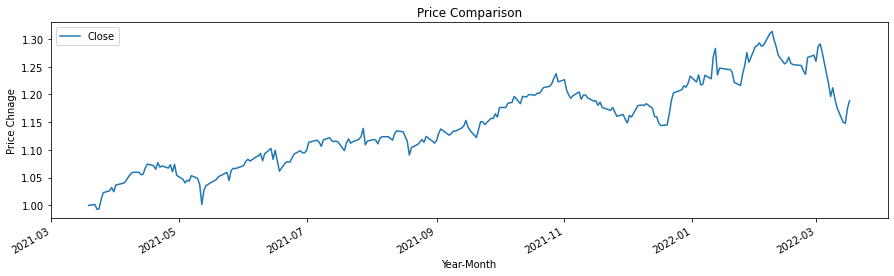

In [5]:
# Plot the absolute price series
plt.figure(figsize=(15,4))
(data['Close']/data['Close'].iloc[0]).plot()

# Set the title and axes label
plt.title('Price Comparison', fontsize=12)
plt.xlabel('Year-Month', fontsize=10)
plt.ylabel('Price Chnage', fontsize=10)
plt.legend()
plt.show()

**2) Examining the MACD Indicator - Potential Entry/ Exits**

In [6]:
# Calculate the MACD line, signal line and MACD histogram
data['macd_line'], data['macd_signal_line'],data['macd_hist'] = ta.MACD(data['Close'])

# Drop the NaN values
data.dropna(inplace=True)

In [7]:
# Generate buy signals
# Use 1 for buy and 0 for no action
data['macd_signal'] = np.where(data['macd_line'] > data['macd_signal_line'], 1, 0)

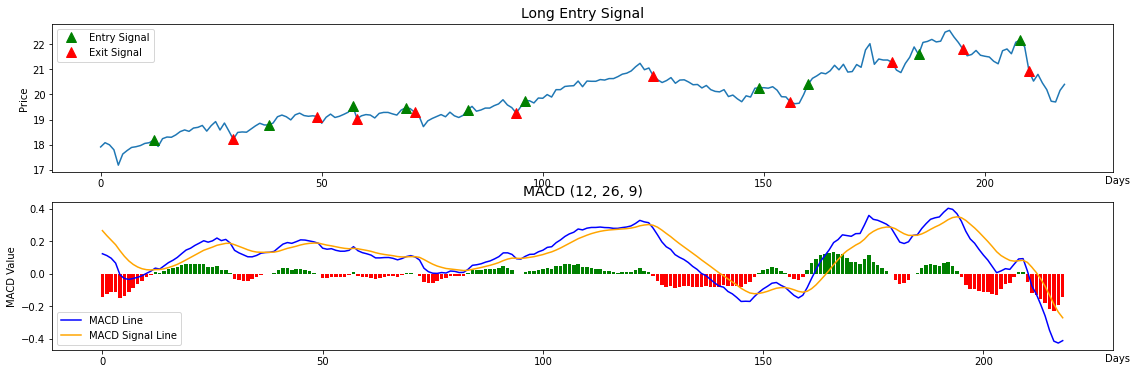

In [8]:
# Show the potential entry/ exit points based on historic timeframe defined for the ticker(s)
data_for_plot = data[start_date:end_date]
num_of_x_values = data_for_plot['Close'].shape[0]

# Define the plot figure
fig = plt.figure(figsize=(19, 6))

# Sub plot for the close price and entry signal
ax1 = fig.add_subplot(211)

# Set the title and axis labels
ax1.set_title('Long Entry Signal', fontsize=14)

# set xlabel to end of graph
ax1.set_xlabel('Days', fontsize=10)
ax1.xaxis.set_label_coords(1.005, -0.025) 
ax1.set_ylabel('Price', fontsize=10)

# Plot close price, using adjusted price, which takes into consideration of stock splits/ merge
ax1.plot(range(num_of_x_values), data_for_plot['Close'])

# Plot long entry points
entry_condition_to_plot = np.where((data_for_plot['macd_signal'] == 1) & (data_for_plot['macd_signal'].shift(1) == 0),
                                   data_for_plot['Close'], np.nan)

ax1.plot(range(num_of_x_values), entry_condition_to_plot, '^', ms=10, label='Entry Signal', color='green')
ax1.legend()

# Plot exit points
entry_condition_to_plot = np.where((data_for_plot['macd_signal'] == 0) & (data_for_plot['macd_signal'].shift(1) == 1),
                                   data_for_plot['Close'], np.nan)

ax1.plot(range(num_of_x_values), entry_condition_to_plot, '^', ms=10, label='Exit Signal', color='red')
ax1.legend()

# Sub plot for the MACD line, signal line and MACD histogram
ax2 = fig.add_subplot(212)
ax2.set_title(('MACD (12, 26, 9)'), fontsize=14)

# set xlabel to end of graph
ax2.set_xlabel('Days', fontsize=10)
ax2.xaxis.set_label_coords(1.005, -0.025)
ax2.set_ylabel('MACD Value', fontsize=10)

# Plot the MACD line and signal line
ax2.plot(range(num_of_x_values), data_for_plot['macd_line'], label='MACD Line', color='blue')
ax2.plot(range(num_of_x_values), data_for_plot['macd_signal_line'], label='MACD Signal Line', color='orange')

# Colour of the MACD histogram
macd_hist_colour = ['green' if (x > 0) else 'red' for x in data_for_plot.macd_hist]

# Plot MACD histogram
ax2.bar(range(num_of_x_values), data_for_plot['macd_hist'], color=macd_hist_colour)
ax2.legend()
plt.show()

**3) Defining Exit Strategy** <br>
A long position is closed if any of the following condition is met.

1) MACD line crosses below signal line <br>
2) Stop loss/ Profit target met (risk/ reward ratio at 1:3) <br>
3) Exit timing (e.g. >30 days) <br>

PNL = entry price - exit price + 2*transaction cost/ slippage (e.g. broker assign price slightly below your buy/ ask price, factor of 2 because this is a round trip cost)


In [9]:
# Transaction cost
# Feel free to change the transaction cost to a value that suits your local market and broker
txn_cost = 0.0002
slippage = 0.0005

# Calculate the PnL
def long_exit(price, time, entry_time, entry_price):
    pnl = round(price.loc[time, 'Close'] - entry_price, 2)
    # Calculate the trading cost and slippage, assuming costs are round trip in nature
    trade_txn = price.loc[time, 'Close'] * txn_cost * 2
    trade_slippage = price.loc[time, 'Close'] * slippage * 2
    trading_cost = trade_txn + trade_slippage
    # Calculate the PnL
    pnl = pnl - trading_cost
    return pd.DataFrame([(entry_time, entry_price, time, price.loc[time, 'Close'], pnl)])

def get_trade_book(price, signal_col, take_profit_target, stop_loss_target):
    # Define the current position and other variables
    current_position = 0
    stop_loss = ''
    take_profit = ''
    entry_time = np.nan
    entry_price = np.nan
    trades = pd.DataFrame()

    # Loop to check the entry and exit logic on each data point
    for time in price.index:
        # Long entry point
        if (current_position == 0) and (price.loc[time, signal_col] == 1):
            current_position = 1
            entry_time = time
            entry_price = price.loc[time, 'Close']

            # Stop loss as a percentage of entry price
            stop_loss = entry_price * (1-stop_loss_target)

            # Profit target as a percentage of entry price
            take_profit = entry_price * (1+take_profit_target)

        # Close the open position based on stop loss and profit target
        elif current_position == 1:
            # Check for stop loss and profit target
            if price.loc[time, 'Close'] < stop_loss or price.loc[time, 'Close'] > take_profit:
                trade_details = long_exit(price, time, entry_time, entry_price)
                trades = trades.append(trade_details, ignore_index=True)
                current_position = 0

        # Close any open position after holding for a month
            if (time-entry_time) >= timedelta(days=30):
                trade_details = long_exit(price, time, entry_time, entry_price)
                trades = trades.append(trade_details, ignore_index=True)
                current_position = 0

    trades.columns = ['Entry Time', 'Entry Price', 'Exit Time', 'Exit Price', 'PNL']
    return trades

**4) Return the Initial Simulated PNL**

In [10]:
# with 1:3 risk/ reward ratio
trade_book_MACD = get_trade_book(data, 'macd_signal', 0.06, 0.02) 
trade_book_MACD.head()

,Entry Time,Entry Price,Exit Time,Exit Price,PNL
0,2021-05-24,18.184278,2021-06-23,18.498610,0.284102
1,2021-06-30,18.786299,2021-07-30,19.150709,0.333189
2,2021-08-13,19.467171,2021-08-19,18.719172,-0.776207
3,2021-09-02,19.390451,2021-10-04,20.189602,0.771735
4,2021-10-05,20.316828,2021-11-04,20.473413,0.131337


In [11]:
# show trades made and total simulated PNL
print('Total trades made:', trade_book_MACD['PNL'].count())
print('Total Profit/ Loss:', trade_book_MACD['PNL'].sum().round(2))

Total trades made: 11
Total Profit/ Loss: -0.9


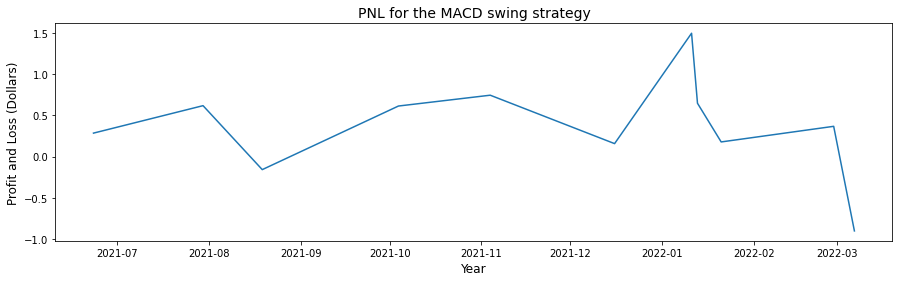

In [12]:
# Define the figure size for the plot
plt.figure(figsize=(15, 4))

# Define the label for the title of the figure
plt.title('PNL for the MACD swing strategy', fontsize=14)

# Define the labels for x-axis and y-axis
plt.xlabel('Year', fontsize=12)
plt.ylabel('Profit and Loss (Dollars)', fontsize=12)

# Plot the PnL
plt.plot(trade_book_MACD['Exit Time'], trade_book_MACD.PNL.cumsum())

plt.show()

**5) Perform Back Testing**

In [13]:
def backtesting_details(trade_book, price_data):
    backtesting_det = pd.DataFrame(index=['Backtesting Strategy'])

    # Number of trades
    backtesting_det['Number of Trades'] = trade_book.shape[0]

    # Startegy start date
    backtesting_det['Strategy Start Date'] = price_data.index[0]

    # Strategy end date
    backtesting_det['Strategy End Date'] = price_data.index[-1]

    # Duration in months
    backtesting_det['Duration'] = "{} months".format(
        (backtesting_det['Strategy End Date'].iloc[0].year -
         backtesting_det['Strategy Start Date'].iloc[0].year) * 12 +
        (backtesting_det['Strategy End Date'].iloc[0].month -
         backtesting_det['Strategy Start Date'].iloc[0].month))

    # Holding time
    trade_book['Holding Time'] = trade_book['Exit Time'] - trade_book['Entry Time']
    backtesting_det['Average holding time'] = trade_book['Holding Time'].mean()
    backtesting_det['Median holding time'] = trade_book['Holding Time'].median()
    backtesting_det['Minimum holding time'] = trade_book['Holding Time'].min()
    backtesting_det['Maximum holding time'] = trade_book['Holding Time'].max()

    display(backtesting_det.astype(object).T)
backtesting_details(trade_book_MACD, data)

,Backtesting Strategy
Number of Trades,11
Strategy Start Date,2021-05-06 00:00:00
Strategy End Date,2022-03-17 00:00:00
Duration,10 months
Average holding time,18 days 04:21:49.090909091
Median holding time,20 days 00:00:00
Minimum holding time,1 days 00:00:00
Maximum holding time,32 days 00:00:00


**6) Plotting the Back Testing Returns**

<Figure size 864x288 with 0 Axes>

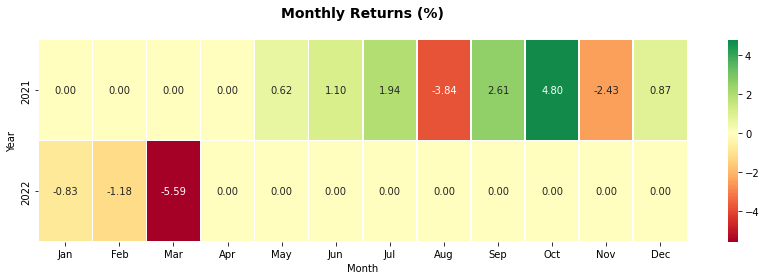

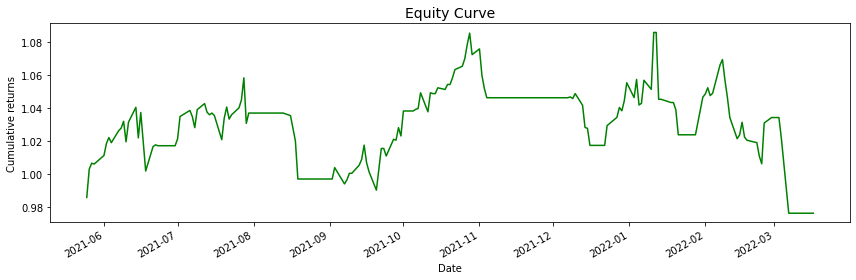

,Returns Metric
Cumulative Return,-2.35
Annualised Return,16236.49
Profit Factor,0.77
Win Rate,54.54


In [14]:
def return_metric(trade_book, price_data):
    import monthly_returns_heatmap as mrh

    return_metrics = pd.DataFrame(index=['Returns Metric'])

    # Add the positions to the price_data based on the trade book
    price_data['positions'] = np.nan
    price_data.loc[list(trade_book['Entry Time']), 'positions'] = 1
    price_data.loc[list(trade_book['Exit Time']), 'positions'] = 0
    price_data['positions'].ffill(inplace=True)

    # Add the PNL column based on the trade book
    price_data['PNL'] = 0
    price_data.loc[list(trade_book['Entry Time']), 'PNL'] = trade_book['PNL'].values

    # Calculate the strategy returns
    price_data['strategy_returns'] = price_data['positions'].shift(1) * price_data['Close'].pct_change()

    # Calculate the cumulative returns
    price_data['cumulative_returns'] = (1+price_data['strategy_returns']).cumprod()
    return_metrics['Cumulative Return'] = (price_data['cumulative_returns'][-1] - 1)*100

    # Calculate the annualized returns
    return_metrics['Annualised Return'] = ((1+price_data['cumulative_returns'][-1]) **(252*6.5/price_data.shape[0]) - 1) * 100

    # Calculate profit factor
    sum_of_profit = price_data[price_data['PNL'] > 0]['PNL'].sum().round(3)
    sum_of_loss = -price_data[price_data['PNL'] < 0]['PNL'].sum().round(3)
    return_metrics['Profit Factor'] = (sum_of_profit / sum_of_loss).round(3)

    # Calculate Win/Loss Ratio
    count_of_profit = price_data[price_data['PNL'] > 0]['PNL'].count()
    count_of_loss = price_data[price_data['PNL'] < 0]['PNL'].count()
    return_metrics['Win Rate'] = (count_of_profit / (count_of_profit+count_of_loss) * 100).round(3)

    # Heatmap of month vs year returns
    fig = plt.figure(figsize=(12, 4))
    mrh.plot(price_data['strategy_returns'], figsize=(12,4))
    plt.tight_layout()
    plt.show()

    # Plot cumulative strategy returns
    price_data['cumulative_returns'].plot(figsize=(12, 4), color='green')
    plt.title('Equity Curve', fontsize=14)
    plt.ylabel('Cumulative returns')
    plt.tight_layout()
    plt.show()

    display(return_metrics.round(2).T)
    
return_metric(trade_book_MACD, data)

**7) Establishing the Risk Matrix**

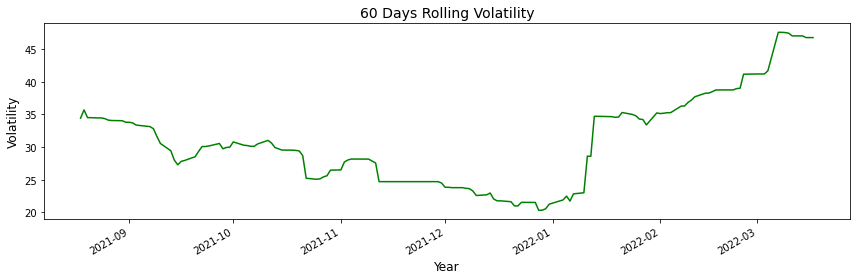

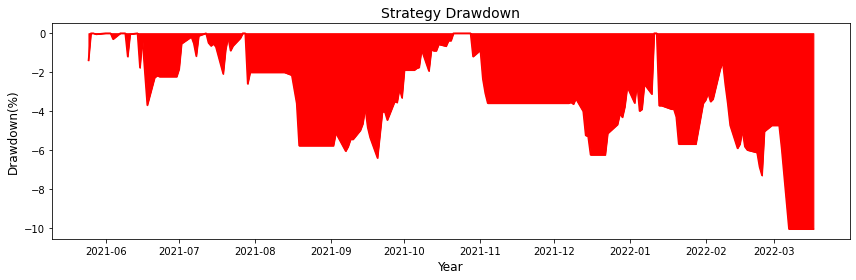

,Risk Metric
Annualised Volatility,34.90%
Maximum Drawdown,-10.06%


In [15]:
def risk_metric(trade_book, price_data):

    risk_metrics = pd.DataFrame(index=['Risk Metric'])

    # Add the positions to the price_data based on the trade book
    price_data['positions'] = np.nan
    price_data.loc[list(trade_book['Entry Time']), 'positions'] = 1
    price_data.loc[list(trade_book['Exit Time']), 'positions'] = 0
    price_data['positions'].ffill(inplace=True)

    # Calculate the strategy returns
    price_data['strategy_returns'] = price_data['positions'].shift(1) * \
                                     price_data['Close'].pct_change()

    # Calculate the cumulative returns
    price_data['cumulative_returns'] = (1+price_data['strategy_returns']).cumprod()

    risk_metrics['Annualised Volatility'] = "{0:.2f}%".format(
        price_data['strategy_returns'].std()*np.sqrt(252*6.5) * 100)

    # 60 days Rolling estimation of volatility
    window_size = 60
    price_data['rolling_volatility'] = price_data['strategy_returns'].rolling(window_size).std() * np.sqrt(252*6.5) * 100
    price_data['rolling_volatility'].plot(figsize=(12,4), color='green')
    plt.title('60 Days Rolling Volatility', fontsize=14)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Volatility', fontsize=12)
    plt.tight_layout()
    plt.show()

    # ---------------------Max drawdown---------------------
    # Calculate the running maximum
    running_max = np.maximum.accumulate(price_data['cumulative_returns'].dropna())
    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1
    # Calculate the percentage drawdown
    drawdown = ((price_data['cumulative_returns'])/running_max - 1) * 100

    # Calculate the maximum drawdown
    risk_metrics['Maximum Drawdown'] = "{0:.2f}%".format(drawdown.min())

    # Plotting the drawdowns
    fig = plt.figure(figsize=(12, 4))

    # Plot max drawdown
    plt.plot(drawdown, color='red')
    plt.figsize=(12,4)
    # Fill in-between the drawdown
    plt.fill_between(drawdown.index, drawdown.values, color='red')
    plt.title('Strategy Drawdown', fontsize=14)
    plt.ylabel('Drawdown(%)', fontsize=12)
    plt.xlabel('Year', fontsize=12)

    plt.tight_layout()
    plt.show()

    display(risk_metrics.round(2).T)

risk_metric(trade_book_MACD, data)

In [16]:
def risk_adjusted_return_metric(trade_book, price_data):

    risk_adjusted_return_metrics = pd.DataFrame(index=['Risk Adjusted Returns Metric'])

    # ---------------------Positions---------------------
    # Add the positions to the price_data based on the trade book
    price_data['positions'] = np.nan
    price_data.loc[list(trade_book['Entry Time']), 'positions'] = 1
    price_data.loc[list(trade_book['Exit Time']), 'positions'] = 0
    price_data['positions'].ffill(inplace=True)

    # ---------------------Startegy returns---------------------
    # Calculate the strategy returns
    price_data['strategy_returns'] = price_data['positions'].shift(1) * \
                                     price_data['Close'].pct_change()

    # ---------------------Cumulative returns---------------------
    # Calculate the cumulative returns
    price_data['cumulative_returns'] = (1 + price_data['strategy_returns']).cumprod()

    # ---------------------Sharpe ratio---------------------
    # assuming risk-free rate = 0
    risk_adjusted_return_metrics['Sharpe ratio'] = round(price_data['strategy_returns'].mean()/
                   price_data['strategy_returns'].std() * np.sqrt(252*6.5), 2)

    # ---------------------Sortino ratio---------------------
    # assuming risk-free rate = 0
    std_neg = price_data['strategy_returns'][price_data['strategy_returns'] < 0].std()
    risk_adjusted_return_metrics['Sortino ratio'] = round(price_data['strategy_returns'].mean()/
                    std_neg * np.sqrt(252*7), 2)

    # ---------------------Calmar ratio---------------------
    # Annualised return
    annualised_return = ((1 + price_data['cumulative_returns'][-1]) **
                         (252*7/price_data.shape[0]) - 1)
    # Max drawdown
    # Calculate the running maximum
    running_max = np.maximum.accumulate(price_data['cumulative_returns'].dropna())
    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1
    # Calculate the percentage drawdown
    drawdown = price_data['cumulative_returns']/running_max - 1

    # Calculate the maximum drawdown
    max_dd = drawdown.min()
    # assuming risk-free rate = 0
    risk_adjusted_return_metrics['Calmar ratio'] = round(annualised_return/abs(max_dd), 2)

    display(risk_adjusted_return_metrics.astype(object).T)


risk_adjusted_return_metric(trade_book_MACD, data)

,Risk Adjusted Returns Metric
Sharpe ratio,-0.37
Sortino ratio,-0.39
Calmar ratio,2393.67


**8) Bulding the "Analyze Performance" Function**

In [19]:
# creating a function to analyse the performance of the strategy
def analyse_performance(trade_book, price_data):
    """
    Analyse the performance of the strategy.
    """
    # Call backtesting_details
    backtesting_details(trade_book, price_data)
    # Call return_metric
    return_metric(trade_book, price_data)
    # Call risk_metric
    risk_metric(trade_book, price_data)
    # Call risk_adjusted_return_metric
    risk_adjusted_return_metric(trade_book, price_data)

**9) Adding Williams Fractal Indicators**

In [20]:
# Function to find the bullish fractal
def bullish_fractal(five_bars):
    if five_bars[2] == min(five_bars):
        return 1
    else:
        return 0

# Function to find the bearish fractal
def bearish_fractal(five_bars):
    if five_bars[2] == max(five_bars):
        return -1
    else:
        return 0

# Finding the fractal signals
data['bull_fractal'] = data['Low'].rolling(5).apply(bullish_fractal)
data['bear_fractal'] = data['High'].rolling(5).apply(bearish_fractal)
data['fractal_signal'] = (data['bear_fractal'] + data['bull_fractal']).shift(1)

# Drop the NaN values
data.dropna(inplace=True)

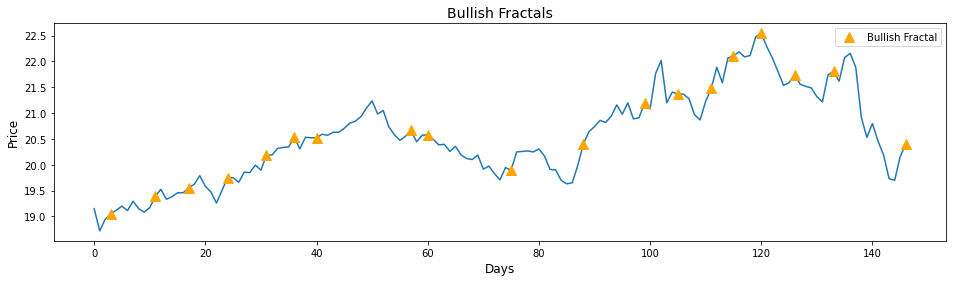

In [21]:
# Show the last 100 points for illustration purposes
data_for_plot = data[start_date: end_date]
num_of_x_values = data_for_plot['Close'].shape[0]

# Define the plot figure
plt.figure(figsize=(16, 4))

# Set the title and axis labels
plt.title('Bullish Fractals', fontsize=14)
plt.xlabel('Days', fontsize=12)
plt.ylabel('Price', fontsize=12)

# Plot close price
plt.plot(range(num_of_x_values), data_for_plot['Close'])

# Plot long entry points
entry_condition_to_plot = np.where((data_for_plot['bull_fractal'] == 1), data_for_plot['Close'], np.nan)

plt.plot(range(num_of_x_values), entry_condition_to_plot, '^',
         ms=10, label='Bullish Fractal', color='orange')
plt.legend()

plt.show()

**10) Plotting the Back Testing Returns for William Fractals**

In [22]:
# Define the take profit and stop loss levels
take_profit = 0.06
stop_loss = 0.02

# Get the trade book
trade_book_fractal = get_trade_book(data, 'fractal_signal', take_profit, stop_loss)

trade_book_fractal.head()

,Entry Time,Entry Price,Exit Time,Exit Price,PNL
0,2021-08-24,19.121941,2021-09-23,19.749208,0.602351
1,2021-10-04,20.189602,2021-11-03,20.581064,0.361187
2,2021-11-09,20.444052,2021-11-26,19.915581,-0.557882
3,2021-12-23,20.639332,2022-01-12,22.017284,1.349176
4,2022-01-19,21.368248,2022-01-24,20.868990,-0.529217


,Backtesting Strategy
Number of Trades,7
Strategy Start Date,2021-08-18 00:00:00
Strategy End Date,2022-03-17 00:00:00
Duration,7 months
Average holding time,19 days 06:51:25.714285714
Median holding time,20 days 00:00:00
Minimum holding time,5 days 00:00:00
Maximum holding time,30 days 00:00:00


<Figure size 864x288 with 0 Axes>

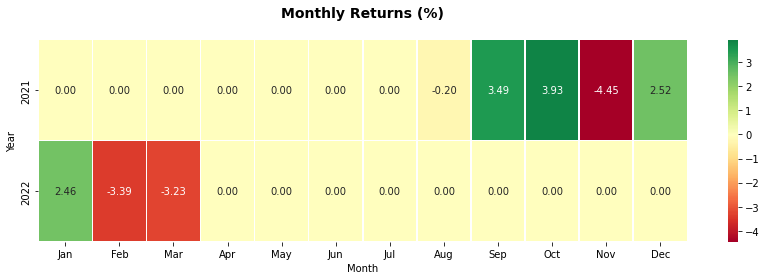

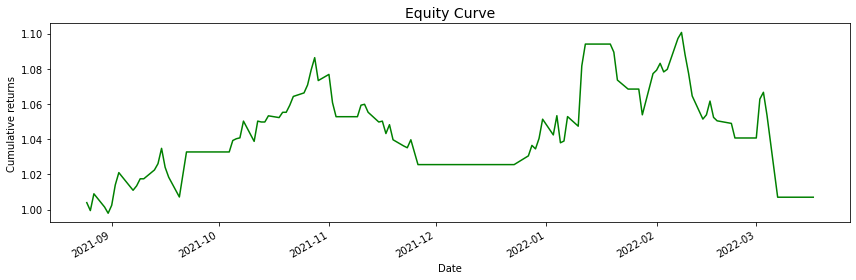

,Returns Metric
Cumulative Return,0.71
Annualised Return,235110.75
Profit Factor,0.96
Win Rate,42.86


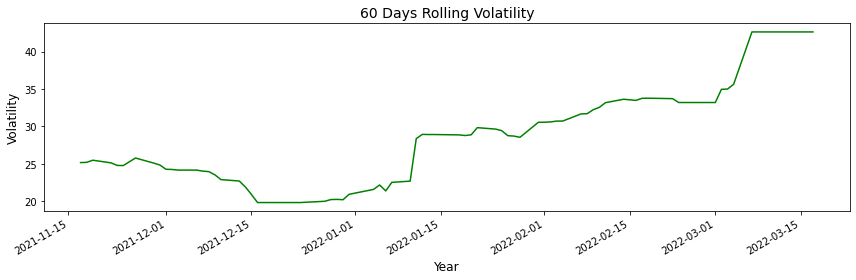

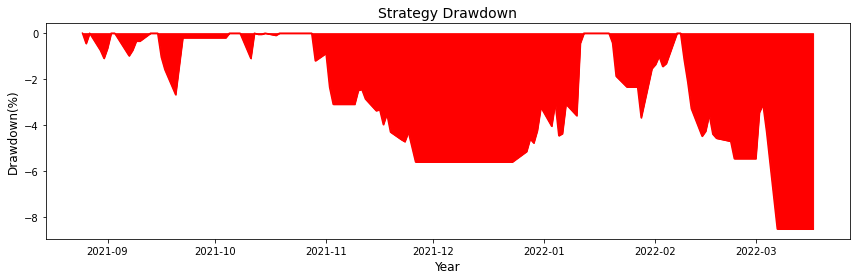

,Risk Metric
Annualised Volatility,32.63%
Maximum Drawdown,-8.50%


,Risk Adjusted Returns Metric
Sharpe ratio,0.41
Sortino ratio,0.47
Calmar ratio,50240.44


In [23]:
# Analyse the strategy performance by passing the trade book and the price data
analyse_performance(trade_book_fractal, data)

**11) Combining MACD with Williams Fractal Indicators**

In [24]:
# Finding the fractal signals
data['bull_fractal'] = data['Low'].rolling(5).apply(bullish_fractal)
data['bear_fractal'] = data['High'].rolling(5).apply(bearish_fractal)
data['fractal_signal'] = (data['bear_fractal'] + data['bull_fractal']).shift(1)

# Finding the signals using MACD
data['macd'], data['macd_signal_line'], data['macd_hist'] = ta.MACD(data['Close'])
data['macd_signal'] = np.where(data['macd'] > data['macd_signal_line'], 1, 0)

# Combine the fractal and MACD signals in the column named composite_signal
data['composite_signal'] = np.where((data['fractal_signal'] == 1) & (data['macd_signal'] == 1), 1, 0)

# Drop the NaN values
data.dropna(inplace=True)

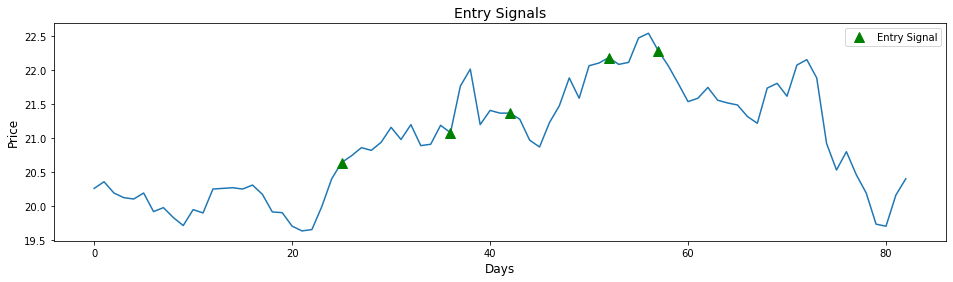

In [25]:
# Show data plot based on start date and end date provided
data_for_plot = data[start_date: end_date]
num_of_x_values = data_for_plot['Close'].shape[0]

# Define the plot figure
plt.figure(figsize=(16, 4))

# Set the title and axis labels
plt.title('Entry Signals', fontsize=14)
plt.xlabel('Days', fontsize=12)
plt.ylabel('Price', fontsize=12)

# Plot close price
plt.plot(range(num_of_x_values), data_for_plot['Close'])

# Plot long entry points
entry_condition_to_plot = np.where((data_for_plot['composite_signal'] == 1), data_for_plot['Close'], np.nan)

plt.plot(range(num_of_x_values), entry_condition_to_plot, '^', ms=10, label='Entry Signal', color='green')
plt.legend()

plt.show()

In [26]:
# Define the take profit and stop loss levels - 1:3 ratio
take_profit = 0.06
stop_loss = 0.02

# Get the trade book
trade_book_fractal = get_trade_book(data, 'composite_signal', take_profit, stop_loss)

trade_book_fractal.head()

,Entry Time,Entry Price,Exit Time,Exit Price,PNL
0,2021-12-23,20.639332,2022-01-12,22.017284,1.349176
1,2022-01-19,21.368248,2022-01-24,20.868990,-0.529217
2,2022-02-02,22.187033,2022-02-14,21.537996,-0.680153


**12) Performance Evaluation**

,Backtesting Strategy
Number of Trades,3
Strategy Start Date,2021-11-17 00:00:00
Strategy End Date,2022-03-17 00:00:00
Duration,4 months
Average holding time,12 days 08:00:00
Median holding time,12 days 00:00:00
Minimum holding time,5 days 00:00:00
Maximum holding time,20 days 00:00:00


<Figure size 864x288 with 0 Axes>

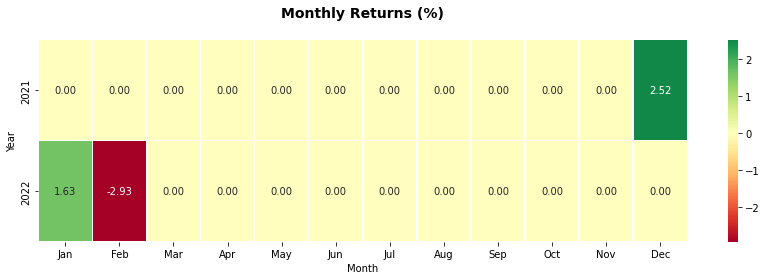

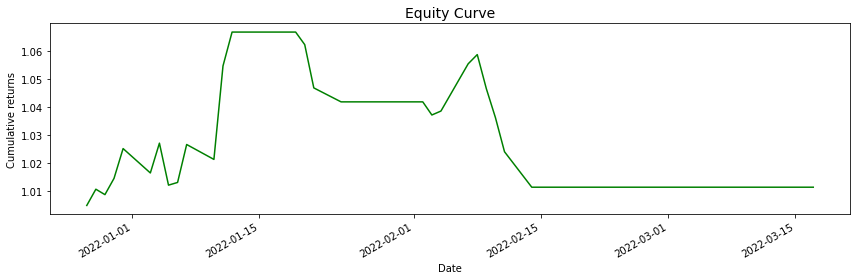

,Returns Metric
Cumulative Return,1.14
Annualised Return,97580251.22
Profit Factor,1.12
Win Rate,33.33


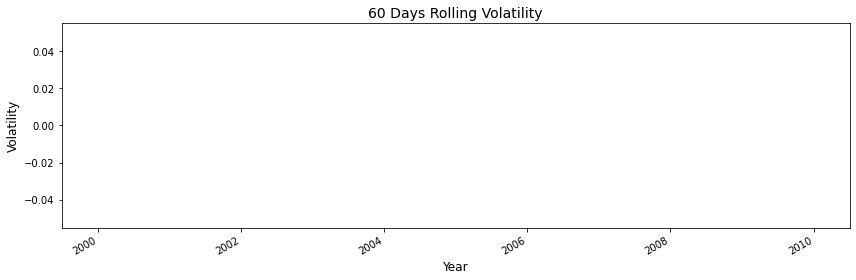

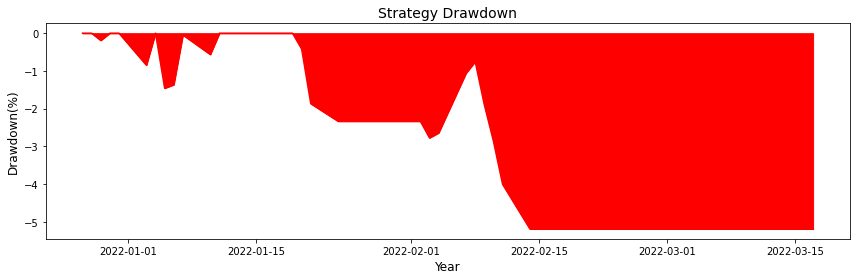

,Risk Metric
Annualised Volatility,29.97%
Maximum Drawdown,-5.19%


,Risk Adjusted Returns Metric
Sharpe ratio,1.23
Sortino ratio,2.15
Calmar ratio,54278888.22


In [27]:
# Analyse the strategy performance by passing the trade book and the price data
analyse_performance(trade_book_fractal, data)

**13) Putting it Together**

In [28]:
# identify trading strategy for the tickers
tickers = ['M44U.SI', 'N2IU.SI', 'S63.SI', 'ME8U.SI', 'C2PU.SI', 'F34.SI', 'F9D.SI', 'E5H.SI', 'V03.SI', 'T82U.SI']
start_date = '2021-3-19'
end_date = '2022-3-18'
take_profit = 0.06
stop_loss = 0.02

In [29]:
def get_price_data(ticker):
  data = yf.download(ticker, start_date, end_date, auto_adjust=True)
  return data

data.head() 

,Open,High,Low,Close,Volume,macd_line,macd_signal_line,macd_hist,macd_signal,positions,PNL,strategy_returns,cumulative_returns,rolling_volatility,bull_fractal,bear_fractal,fractal_signal,macd,composite_signal
Date,,,,,,,,,,,,,,,,,,,
2021-11-17,20.385334,20.453839,20.170031,20.258110,2496200,0.001123,0.090977,-0.085877,0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.005099,0
2021-11-18,20.258109,20.385333,20.228748,20.355972,1534900,-0.011183,0.071281,-0.078783,0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,-0.007502,0
2021-11-19,20.228749,20.346188,20.101525,20.189602,1765200,-0.033968,0.050912,-0.081474,0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,-0.030561,0
2021-11-22,20.209176,20.297255,20.081952,20.121098,1793700,-0.056898,0.029981,-0.083725,0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,-0.053744,0
2021-11-23,20.218962,20.228748,20.072164,20.101524,1962800,-0.075775,0.009414,-0.082270,0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,-0.072856,0


In [ ]:
PNL_list = []
for ticker in tickers:
  temp1 = get_price_data(ticker)

  # Finding the fractal signals
  temp1['bull_fractal'] = temp1['Low'].rolling(5).apply(bullish_fractal)
  temp1['bear_fractal'] = temp1['High'].rolling(5).apply(bearish_fractal)
  temp1['fractal_signal'] = (temp1['bear_fractal'] + temp1['bull_fractal']).shift(1)
  temp1_fractal = get_trade_book(temp1, 'fractal_signal', take_profit, stop_loss)
  fractal_PNL = temp1_fractal['PNL'].sum().round(2)

  # Finding MACD signal
  temp1['macd_line'], temp1['macd_signal_line'],temp1['macd_hist'] = ta.MACD(temp1['Close'])
  temp1.dropna(inplace=True)
  temp1['macd_signal'] = np.where(temp1['macd_line'] > temp1['macd_signal_line'], 1, 0)
  trade_book_MACD = get_trade_book(temp1, 'macd_signal', 0.06, 0.02) 
  macd_PNL = trade_book_MACD['PNL'].sum().round(2)

  # Combine the fractal and MACD signals in the column named composite_signal
  temp1['composite_signal'] = np.where((temp1['fractal_signal'] == 1) & (temp1['macd_signal'] == 1), 1, 0)
  temp1.dropna(inplace=True)
  trade_book_fractal = get_trade_book(temp1, 'composite_signal', take_profit, stop_loss)
  composite_PNL = trade_book_fractal['PNL'].sum().round(2)

  PNL_list.append([ticker, macd_PNL, fractal_PNL, composite_PNL])

In [31]:
result=pd.DataFrame(PNL_list, columns=['Ticker', 'MACD Returns', 'Fractal Returns', 'Composite Returns'])
result.sort_values(by=['Composite Returns', 'MACD Returns'], ascending=False)

,Ticker,MACD Returns,Fractal Returns,Composite Returns
4,C2PU.SI,0.67,0.07,0.74
5,F34.SI,-0.45,-0.38,0.51
2,S63.SI,0.16,0.11,0.35
9,T82U.SI,0.20,0.06,0.07
7,E5H.SI,0.05,0.07,0.03
6,F9D.SI,-0.13,-0.11,-0.08
1,N2IU.SI,-0.28,-0.17,-0.18
0,M44U.SI,-0.08,-0.15,-0.20
3,ME8U.SI,-0.34,-0.35,-0.38
8,V03.SI,-1.92,-4.14,-2.21
